# **Dog vs Cat classifier**

In [110]:
# import modules

import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import os
import zipfile
from PIL import Image;
import torch
import torch.nn as nn;
from torch.utils.data import Dataset;
from torch.utils.data import DataLoader;
import torchvision.models as models;
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm


In [111]:
# print input files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [112]:
# Unzip input files

if 'train' not in os.listdir('.'):
    with zipfile.ZipFile("../input/dogs-vs-cats/train.zip","r") as z:
        z.extractall(".")

if 'test1' not in os.listdir('.'):
    with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip","r") as z:
        z.extractall(".")

In [113]:
# make train dataframe
train_folder = '/kaggle/working/train/'

train_df = pd.DataFrame();
train_df['Filename'] = os.listdir(train_folder)
train_df['ID'] = np.arange(len(train_df))
train_df['Label'] = train_df['Filename'].apply(lambda x: x.split('.')[0])
train_df.loc[train_df['Label']=='cat','Label'] = 0;
train_df.loc[train_df['Label']=='dog','Label'] = 1;
train_df['Label'] = train_df['Label'].astype(int)
train_df.head()

,Filename,ID,Label
0,dog.1323.jpg,0,1
1,cat.4702.jpg,1,0
2,dog.1404.jpg,2,1
3,dog.2501.jpg,3,1
4,dog.7101.jpg,4,1


In [114]:
train_df['Label'].dtype

dtype('int64')

In [115]:
# make test dataframe
test_folder = '/kaggle/working/test1/'

test_df = pd.DataFrame();
test_df['Filename'] = os.listdir(test_folder)
test_df['ID'] = np.arange(len(test_df))
test_df['Label'] = np.nan
test_df.head()

,Filename,ID,Label
0,1244.jpg,0,NaN
1,5593.jpg,1,NaN
2,1745.jpg,2,NaN
3,9084.jpg,3,NaN
4,5178.jpg,4,NaN


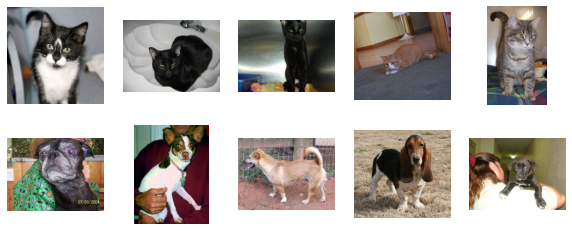

In [116]:
# draw example train images

cat_example = train_df.loc[train_df['Label']==0,'Filename'].values[:5]
dog_example = train_df.loc[train_df['Label']==1,'Filename'].values[:5]

plt.figure(figsize=(10,4))
for i in range(5):
    img = Image.open(train_folder+cat_example[i]);
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.axis('off')
    img = Image.open(train_folder+dog_example[i]);
    plt.subplot(2,5,i+6)
    plt.imshow(img)
    plt.axis('off')    

In [117]:
# Dataset

class CatDog_dataset(Dataset):
    def __init__(self, df, filedir, transform=None):
        super().__init__();
        self.df = df
        self.filedir = filedir
        self.transform = transform;
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        fname = self.df.iloc[idx,0];
        
        img = Image.open(self.filedir+fname);
        img = np.array(img)
        label = self.df.iloc[idx,2];
        
        if self.transform:
            transformed = self.transform(image=img);
        
        return transformed['image'], label

In [118]:
## Data transformation

# for training
transform_train = A.Compose([                             
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.SmallestMaxSize(max_size=230),
    A.CenterCrop(224,224),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()]);

# for validation, test
transform_test = A.Compose([
    A.SmallestMaxSize(max_size=230),
    A.CenterCrop(224,224),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()]);

In [119]:
# train, validation split
skf = StratifiedKFold(n_splits=5,shuffle=True);

In [120]:
# transfer learning from VGG16
vgg16 = models.vgg16(pretrained=True)

class DogCat_Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = vgg16.features;
        self.avgpool = vgg16.avgpool;
        self.flatten = torch.flatten;
        self.classifier = nn.Sequential(
            nn.Linear(in_features=25088, out_features=1000, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=1000, out_features=100, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=100, out_features=2, bias=True)
        )
    def forward(self,x):
        x = self.features(x);
        x = self.avgpool(x);
        x = self.flatten(x,1);
        x = self.classifier(x);
        return x
    
myModel = DogCat_Classifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel.to(device)

DogCat_Classifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding

In [121]:
# to save model during training

model_path = '/kaggle/working/dogcat_classifier.pt';
train_loss = [];
valid_loss = [];

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    myModel.load_state_dict(checkpoint['state_dict'])
    train_loss = checkpoint['train_loss'];
    valid_loss = checkpoint['valid_loss'];
    return model, train_loss, valid_loss

#myModel, train_loss, valid_loss = load_checkpoint(model_path)

In [122]:
# loss function
def loss_fun(y_pred, y_true):
    return nn.CrossEntropyLoss()(y_pred, y_true);

### accuracy score
def compute_accuracy(y_pred, y_true):
    y_answer = np.argmax(y_pred.detach().cpu().numpy(),axis=1);
    y_true = y_true.detach().cpu().numpy();
    return accuracy_score(y_true, y_answer)

In [123]:
## unfreeze classifier_layer
for param in myModel.parameters():
    param.requires_grad = False

## unfreeze classifier_layer
for param in myModel.classifier.parameters():
    param.requires_grad = True
    
### Optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, myModel.parameters()),
                             lr=learning_rate)    

In [124]:
split = 0
for train_idx, valid_idx in skf.split(train_df['ID'],train_df['Label']):
    
    split += 1
    trainNow = train_df.iloc[train_idx,:];
    validNow = train_df.iloc[valid_idx,:];
    
    # dataset
    train_ds = CatDog_dataset(trainNow,train_folder,transform=transform_train);
    valid_ds = CatDog_dataset(validNow,train_folder,transform=transform_test);
    
    # data loaer
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=False, drop_last=True)
    valid_loader = DataLoader(valid_ds, batch_size=16, shuffle=False, drop_last=True)
    
    for epoch in range(3):
        
        # train
        myModel.train()
        loss = [];
        acc = [];
        
        pbar = tqdm(enumerate(train_loader), total=len(train_loader));
        for step, (imgs, image_labels) in pbar:
            imgs, image_labels = imgs.to(device), image_labels.to(device);
            y_pred = myModel(imgs);
            lossNow = loss_fun(y_pred,image_labels);
            accNow = compute_accuracy(y_pred, image_labels)
            y_answer = np.argmax(y_pred.detach().cpu().numpy(),axis=1);
            loss.append(lossNow.item());
            acc.append(accNow);
            # Zero gradients before a backward pass, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            lossNow.backward()
            optimizer.step()
            pbar.set_postfix({'loss': str(lossNow.item()),'accuracy': accNow})
        print('split#'+str(split)+', epoch#'+str(epoch)+': train loss = '+str(np.mean(loss))+', train acc = '+str(np.mean(acc)));
        train_loss.append(np.mean(loss));        

        # valid
        myModel.eval()
        loss = [];
        acc = [];
        
        pbar = tqdm(enumerate(valid_loader), total=len(valid_loader));
        for step, (imgs, image_labels) in pbar:
            imgs, image_labels = imgs.to(device), image_labels.to(device);
            y_pred = myModel(imgs);
            lossNow = loss_fun(y_pred,image_labels);
            accNow = compute_accuracy(y_pred, image_labels)
            y_answer = np.argmax(y_pred.detach().cpu().numpy(),axis=1);
            loss.append(lossNow.item());
            acc.append(accNow);
            pbar.set_postfix({'loss': str(lossNow.item()),'accuracy': accNow})
        print('split#'+str(split)+', epoch#'+str(epoch)+': valid loss = '+str(np.mean(loss))+', valid acc = '+str(np.mean(acc)));
        valid_loss.append(np.mean(loss));        
        
        checkpoint = {'state_dict': myModel.state_dict(),
                      'optimizer' : optimizer.state_dict(),
                      'train_loss': train_loss,
                      'valid_loss': valid_loss}
        torch.save(checkpoint, model_path)        

  0%|          | 1/312 [00:00<00:31,  9.80it/s, loss=0.002138755517080426, accuracy=1]

split#1, epoch#0: train loss = 0.16053038314227014, train acc = 0.9345


100%|██████████| 312/312 [00:33<00:00,  9.29it/s, loss=0.015609433874487877, accuracy=1]    


split#1, epoch#0: valid loss = 0.04390441749567869, valid acc = 0.9833733974358975


  0%|          | 1/312 [00:00<00:32,  9.59it/s, loss=0.0005061929114162922, accuracy=1]

split#1, epoch#1: train loss = 0.11833185142166913, train acc = 0.95385


100%|██████████| 312/312 [00:33<00:00,  9.29it/s, loss=0.0141369653865695, accuracy=1]     


split#1, epoch#1: valid loss = 0.044555415332623825, valid acc = 0.983573717948718


  0%|          | 1/312 [00:00<00:32,  9.71it/s, loss=0.0010904342634603381, accuracy=1]

split#1, epoch#2: train loss = 0.1021698000407312, train acc = 0.9605


100%|██████████| 312/312 [00:32<00:00,  9.53it/s, loss=0.00831984356045723, accuracy=1]     


split#1, epoch#2: valid loss = 0.0421365788150256, valid acc = 0.9827724358974359


  1%|          | 2/312 [00:00<00:30, 10.27it/s, loss=0.19224897027015686, accuracy=0.938]

split#2, epoch#0: train loss = 0.0996437743086717, train acc = 0.9622


100%|██████████| 312/312 [00:33<00:00,  9.34it/s, loss=0.002189589198678732, accuracy=1]    


split#2, epoch#0: valid loss = 0.04166624671406083, valid acc = 0.9847756410256411


  1%|          | 2/312 [00:00<00:30, 10.16it/s, loss=0.18526697158813477, accuracy=0.938]

split#2, epoch#1: train loss = 0.08804696053454682, train acc = 0.9649


100%|██████████| 312/312 [00:33<00:00,  9.26it/s, loss=0.011090059764683247, accuracy=1]    


split#2, epoch#1: valid loss = 0.04084172243271903, valid acc = 0.985176282051282


  0%|          | 1/312 [00:00<00:41,  7.57it/s, loss=0.16428722441196442, accuracy=0.938]

split#2, epoch#2: train loss = 0.0793801792913815, train acc = 0.9696


100%|██████████| 312/312 [00:33<00:00,  9.43it/s, loss=0.0038461373187601566, accuracy=1]   


split#2, epoch#2: valid loss = 0.05491116296181139, valid acc = 0.9831730769230769


  0%|          | 1/312 [00:00<00:31,  9.77it/s, loss=0.005525611806660891, accuracy=1]

split#3, epoch#0: train loss = 0.08249784421185904, train acc = 0.96905


100%|██████████| 312/312 [00:33<00:00,  9.40it/s, loss=0.010416841134428978, accuracy=1]    


split#3, epoch#0: valid loss = 0.021584591056288523, valid acc = 0.9917868589743589


  0%|          | 1/312 [00:00<00:31,  9.72it/s, loss=0.00263048242777586, accuracy=1]

split#3, epoch#1: train loss = 0.07948978732022514, train acc = 0.9716


100%|██████████| 312/312 [00:33<00:00,  9.34it/s, loss=0.01447201892733574, accuracy=1]    


split#3, epoch#1: valid loss = 0.022256098995228513, valid acc = 0.9909855769230769


  0%|          | 1/312 [00:00<00:31,  9.82it/s, loss=0.005903871729969978, accuracy=1]

split#3, epoch#2: train loss = 0.0744219426293028, train acc = 0.97175


100%|██████████| 312/312 [00:32<00:00,  9.49it/s, loss=0.009200118482112885, accuracy=1]    


split#3, epoch#2: valid loss = 0.02337913466687233, valid acc = 0.9909855769230769


  0%|          | 0/312 [00:00<?, ?it/s, loss=0.0002800433139782399, accuracy=1]

split#4, epoch#0: train loss = 0.06866167965088243, train acc = 0.9743


100%|██████████| 312/312 [00:34<00:00,  9.05it/s, loss=0.05134157836437225, accuracy=0.938] 


split#4, epoch#0: valid loss = 0.018792385194558666, valid acc = 0.991386217948718


100%|██████████| 1250/1250 [02:50<00:00,  7.68it/s, loss=0.09112510085105896, accuracy=1]     

KeyboardInterrupt: 

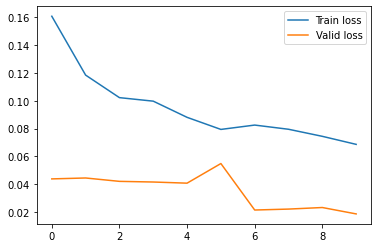

In [128]:
l1, = plt.plot(train_loss, label='Train loss')
l2, = plt.plot(valid_loss, label='Valid loss')
plt.legend(handles=[l1, l2])
plt.xlabel('Epoch #')
plt.ylabel('CrossEntropyLoss')